## Requirements
### 1. Stochatic Environment
Pricing algorithm: Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes.
Bidding algorithm: Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- primal-dual algorithm for truthful auctions
- UCB-like algorithm
### 2. Adversarial Environment
Build an highly non-stationary environment. At an high level, it should include:
- A sequence of competing bids of the other agents (e.g., sampled from a distribution that changes quickly over time)
- For each day, a function specifying the probability with which an user buys for every price (this function changes quickly over time)

Build a pricing strategy discretizing the continuous set of prices p ∈ [0, 1]
Consider a generalized first-price auction. Build a learning algorithms to deal with the bidding problem. In particular, a primal-dual algorithm for non-truthful auctions.
### 3. two extensions for pricing - BONUS IS NOT INCLUDED HERE
We extend the pricing problem along two directions. Since we focus only on pricing, we directly consider a demand curve with noise (differently from previous points in which the demand curve depends on the number of visits and hence on the advertising step).

Build a pricing strategy using the discretization of the prices p ∈ [0, 1] and:
1. sliding-window
2. CUSUM

Build a non-stationary environment for the pricing problem. At an high level:
- Days are partitioned in intervals
- In each interval the demand curve is different
- The demand curve + noise specifies how many buyers while buy for every price depending on the current interval

### 4. Comparing Different Bidding Algorithms
The goal is to compare the performances of different algorithms.
Consider the different algorithms that we have seen for bidding and let them play one against the others in a generalized first-price auction. In particular, consider:
- A primal-dual algorithm for truthful auctions
- A primal-dual algorithm for non-truthful auctions
- A UCB-like approach


# Codes

Stochatic Environment

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, RationalQuadratic, ExpSineSquared, Matern
import matplotlib.pyplot as plt
from scipy.stats import norm 

In [2]:
class PricingEnvironment:
    def __init__(self, max_price=1.0, noise_level=0.1, model='linear'):
        self.max_price = max_price
        self.noise_level = noise_level
        self.model = model
        np.random.seed(42)

    def generate_data(self, n_points=100): # Simulating a demand curve - WE CAN EDIT THIS PURELY RANDOM
        prices = np.linspace(0, self.max_price, n_points)
        
        if self.model == 'linear':
            beta_0 = 1  # Intercept
            beta_1 = -1  # Slope
            purchase_probabilities = beta_0 + beta_1 * prices
            
        elif self.model == 'logit':
            alpha = 0
            beta = -5
            purchase_probabilities = 1 / (1 + np.exp(-(alpha + beta * prices)))
            
        elif self.model == 'probit':
            alpha = 0
            beta = -5
            purchase_probabilities = norm.cdf(alpha + beta * prices)
            
        elif self.model == 'KERNEL':
            purchase_probabilities = np.abs(np.sin(2 * np.pi * prices) * np.exp(-prices * 5) + prices * .10) + .1


        # Noise
        noisy_purchase_probabilities = purchase_probabilities + np.random.normal(0, self.noise_level, n_points)
        
        # P is E [0, 1]
        noisy_purchase_probabilities = np.clip(noisy_purchase_probabilities, 0, 1)
        
        return prices.reshape(-1, 1), noisy_purchase_probabilities


In [3]:
class GaussianProcessPricingModel:
    def __init__(self, kernel=None):
        if kernel is None:
            kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1) + DotProduct() + RationalQuadratic()
        self.model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X, return_std=True)

    def plot(self, X_train, y_train, X_test, y_pred, sigma):
        plt.figure(figsize=(10, 5))
        plt.plot(X_train, y_train, 'r.', markersize=10, label='Observations')
        plt.plot(X_test, y_pred, 'b-', label='Prediction')
        plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue')
        plt.xlabel('Price')
        plt.ylabel('Purchase Probability')
        plt.title('Gaussian Process Regression on Pricing Data with 95% CI')
        plt.legend()
        plt.show()

In [4]:
env = PricingEnvironment(model='KERNEL') # probit, logit, linear, KERNEL
X, y = env.generate_data()

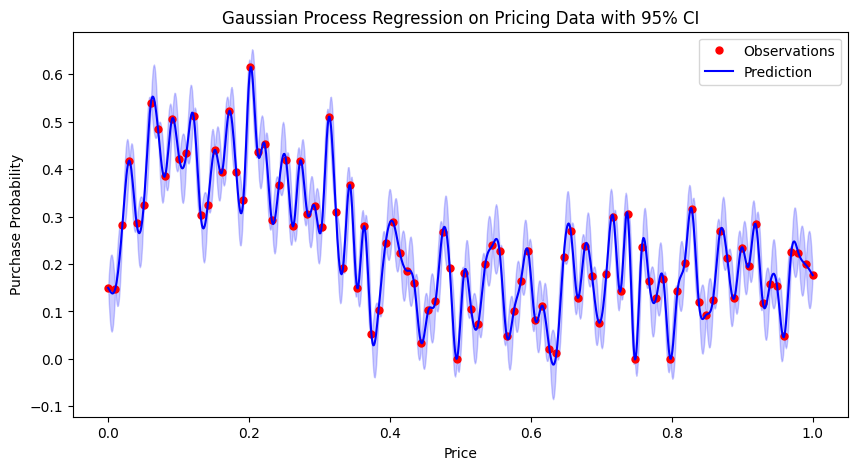

In [5]:
# Gaussian Process Model - PLAY AROUND WITH THIS
gp_model = GaussianProcessPricingModel(kernel = Matern()) # RBF(). WhiteKernel(), None, ExpSineSquared(), RationalQuadratic(), Matern()
gp_model.fit(X, y)

# Prediction and Visualization
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)
y_pred, sigma = gp_model.predict(X_test)
gp_model.plot(X, y, X_test, y_pred, sigma)
